In [3]:
import importlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import decision_learning.benchmarks.shortest_path_grid.data
importlib.reload(decision_learning.benchmarks.shortest_path_grid.data)
from decision_learning.benchmarks.shortest_path_grid.data import piecewise_linear

### Testing Piecewise Linear Function

2024-10-30 13:26:35,083 - decision_learning.benchmarks.shortest_path_grid.data - DEBUG - chg_pt: 0.55
2024-10-30 13:26:35,084 - decision_learning.benchmarks.shortest_path_grid.data - DEBUG - chg_pt: 0.0


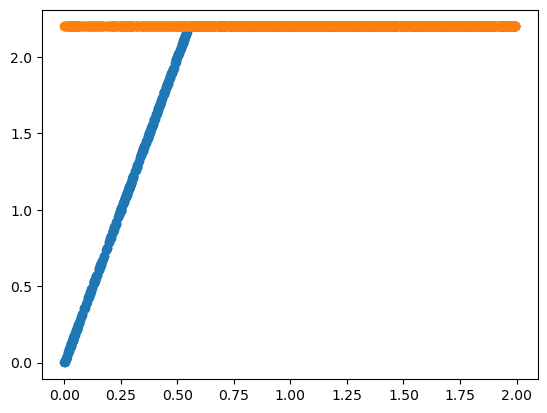

In [4]:
rnd = np.random.RandomState(1)
x = rnd.uniform(low=0, 
            high=2, 
            size=1000)
y_red = piecewise_linear(x,
                    slope0=4, 
                    int0=0,
                    slope1=0, 
                    int1=2.2)
y_blue = piecewise_linear(x,
                    slope0=0, 
                    int0=2.2,
                    slope1=0, 
                    int1=2.2)
plt.scatter(x, y_red)
plt.scatter(x, y_blue)

In [5]:
# Assume list1 and list2 are your lists of arrays
list1 = np.array([1, 2, 3]) 
list2 = np.array([4, 5, 6])

# Concatenate the lists
combined = np.concatenate((list1,list2))

# # Create an array of all possible indices
# all_indices = np.arange(max(combined) + 1)

# # Find the indices not in the combined list
# not_in_combined = np.setdiff1d(all_indices, combined)

# Generate Data

In [6]:
importlib.reload(decision_learning.benchmarks.shortest_path_grid.data)
from decision_learning.benchmarks.shortest_path_grid.data import add_noise, genDataPlant, shortest_path_synthetic_sym_no_noise, shortest_path_synthetic_plant_path

In [7]:
indices_arr = torch.randperm(100000)
indices_arr_test = torch.randperm(100000)

sim = 0
n_arr = [200, 400, 800, 1600]
ep_arr = ['unif', 'normal']
trials = 100

exp_arr = []
for n in n_arr:
    for ep in ep_arr:
        for t in range(trials):
            exp_arr.append([n, ep, t])

exp = exp_arr[sim]
ep_type = exp[1]
trial = exp[2]

# generate data
grid = (5, 5)  # grid size
num_data = exp[0]  # number of training data
num_feat = 5  # size of feature
deg = 6  # polynomial degree
e = .4  # noise width



In [8]:
importlib.reload(decision_learning.benchmarks.shortest_path_grid.data)
from decision_learning.benchmarks.shortest_path_grid.data import add_noise, genData, genDataPlant, shortest_path_synthetic_sym_no_noise, shortest_path_synthetic_plant_path

In [9]:
planted_good_pwl_params = {'slope0':0, 
                    'int0':2,
                    'slope1':0, 
                    'int1':2}
planted_bad_pwl_params = {'slope0':4, 
                    'int0':0,
                    'slope1':0, 
                    'int1':2.2}

In [10]:
data = shortest_path_synthetic_sym_no_noise(num_data=num_data+200,
        num_features=num_feat, 
        grid=grid, 
        deg=deg, 
        seed=indices_arr[trial])


data_plant = shortest_path_synthetic_plant_path(planted_good_pwl_params=planted_good_pwl_params,
                                   planted_bad_pwl_params=planted_bad_pwl_params,
                                   seed=indices_arr[trial],
                                   **data)
data_noise = add_noise(c=data_plant['c_plant'],
          noise_type=ep_type,
          noise_width=e,
          seed=indices_arr[trial])

2024-10-30 13:26:40,257 - decision_learning.benchmarks.shortest_path_grid.data - DEBUG - good_bad_edges: [ 1  4  9 16 24 31 36 39  0  3  8 15 23 30 35 38], remain_edges: [ 2  5  6  7 10 11 12 13 14 17 18 19 20 21 22 25 26 27 28 29 32 33 34 37]
2024-10-30 13:26:40,258 - decision_learning.benchmarks.shortest_path_grid.data - DEBUG - chg_pt: 0.0
2024-10-30 13:26:40,258 - decision_learning.benchmarks.shortest_path_grid.data - DEBUG - chg_pt: 0.55


One genData Function

In [12]:
final_data = genData(num_data=num_data+200,
        num_features=num_feat, 
        grid=grid, 
        deg=deg, 
        noise_type=ep_type,
        noise_width=e,
        seed=indices_arr[trial],     
        plant_edges=False,
        planted_good_pwl_params=planted_good_pwl_params,
        planted_bad_pwl_params=planted_bad_pwl_params)

In [13]:
final_data['cost'].shape

(400, 40)

In [14]:
import decision_learning.modeling.models
importlib.reload(decision_learning.modeling.models)
from decision_learning.modeling.models import LinearRegression

In [15]:
lr_mod = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])

In [16]:
c_pred = lr_mod(torch.tensor(final_data['feat'], dtype=torch.float))

In [17]:
c_pred

tensor([[ 0.2683,  0.6073, -0.2080,  ..., -0.8382, -0.0791, -0.1875],
        [ 0.4596,  0.1046, -0.2358,  ...,  0.4004, -0.6692,  0.4220],
        [-0.1221, -0.1513, -0.1681,  ..., -1.3648,  0.7010, -0.7328],
        ...,
        [ 1.5926,  0.6625,  0.1456,  ...,  0.1185,  0.8618, -0.2957],
        [ 0.2547,  0.7631, -1.0252,  ..., -0.3018,  0.0272,  0.2234],
        [ 0.1512, -0.1579,  0.2593,  ..., -0.5741, -0.5198, -0.0736]],
       grad_fn=<AddmmBackward0>)

# Initial Solution using optimization Solver

In [18]:
from decision_learning.benchmarks.shortest_path_grid.oracle import opt_oracle as shortest_path_solver


Auto-Sklearn cannot be imported.


checking functionality of just `shortest_path_solver` vs `shortestPathModel`

In [19]:
optmodel = shortestPathModel()
optmodel.setObj(c_pred)
ptb_sols, ptb_obj = optmodel.solve()
sol, obj = shortest_path_solver(costs=c_pred, size=5)

torch.all(ptb_sols == sol).item(), torch.all(ptb_obj == obj).item()

(True, True)

# Create Dataset Object

In [20]:
from torch.utils.data import DataLoader
from tqdm import tqdm

import decision_learning.modeling.loss
importlib.reload(decision_learning.modeling.loss)
from decision_learning.modeling.loss import SPODataset, SPOPlusLoss

In [25]:
# get initial 
final_data = genData(num_data=num_data+200,
        num_features=num_feat, 
        grid=grid, 
        deg=deg, 
        noise_type=ep_type,
        noise_width=e,
        seed=indices_arr[trial],     
        plant_edges=False,
        planted_good_pwl_params=planted_good_pwl_params,
        planted_bad_pwl_params=planted_bad_pwl_params)

sol, obj = shortest_path_solver(costs=final_data['cost'], size=5)

dataset = SPODataset(X=final_data['feat'],
           obs_cost=final_data['cost'],
           obs_sol=sol,
           obs_obj=obj)
dataloader = DataLoader(dataset, 
                        batch_size=100, #len(dataset), 
                        shuffle=True,
                       collate_fn=dataset.collate_fn)

Iterate over dataloader example

In [22]:
lr_mod = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])

In [28]:
# Iterate over batches with tqdm progress bar
all_preds = []
lr_mod.eval() # set model to evaluation mode
with torch.no_grad():      
    for batch_idx, batch in enumerate(tqdm(dataloader)):        
        # For example, passing inputs to a model
        print(f"Batch {batch_idx}, batch keys {batch.keys()}")
        pred = lr_mod(batch['X'])

        # Append predictions to list
        all_preds.append(pred)
all_preds = torch.cat(all_preds, dim=0)
        

100%|██████████| 4/4 [00:00<00:00, 656.18it/s]

Batch 0, batch keys dict_keys(['X', 'obs_cost', 'obs_sol', 'obs_obj'])
Batch 1, batch keys dict_keys(['X', 'obs_cost', 'obs_sol', 'obs_obj'])
Batch 2, batch keys dict_keys(['X', 'obs_cost', 'obs_sol', 'obs_obj'])
Batch 3, batch keys dict_keys(['X', 'obs_cost', 'obs_sol', 'obs_obj'])


In [29]:
pred.shape, all_preds.shape

(torch.Size([100, 40]), torch.Size([400, 40]))

# Instantiate Loss Function

## Verify Loss is Same

One training loop example

In [20]:
import inspect

def filter_kwargs(func, kwargs):
    signature = inspect.signature(func)
    valid_args = {key: value for key, value in kwargs.items() if key in signature.parameters}
    return valid_args

In [44]:
from functools import partial

lr_mod = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])
# set adam optimizer
optimizer = torch.optim.Adam(lr_mod.parameters(), lr=0.1)

Double Check Loss Function is Implemented correctly

In [45]:
cp = lr_mod(batch['X'])

Original Function

In [46]:
from decision_learning.modeling.loss import SPOPlusLoss2_O
optmodel = shortestPathModel()
orig_loss_fn = SPOPlusLoss2_O(opt_oracle=optmodel)
orig_loss = orig_loss_fn(pred_cost=cp, 
                         obs_cost=batch['obs_cost'], 
                         obs_sol=batch['obs_sol'], 
                         obs_obj=batch['obs_obj'])

Num of cores: 1


In [53]:
loss_fn = SPOPlusLoss(opt_oracle=partial(shortest_path_solver,size=5))

new_batch = filter_kwargs(loss_fn.forward, batch)
loss2 = loss_fn(pred_cost=cp, **new_batch)

Check Original Implementation and New have same loss

In [54]:
print(orig_loss, loss2)
orig_loss == loss2

(tensor(12.0687, grad_fn=<MeanBackward0>),
 tensor(12.0687, grad_fn=<MeanBackward0>))

Check Original and New have same gradients

# Train Loop
1. Get current batch (requires a dataset object and dataloader)
2. Get Predictions
3. Get necessary components for loss function like current predicted cost solutions
4. Calculate loss function and back propogate

In [68]:
lr_mod_o = LinearRegression(input_dim=final_data['feat'].shape[1],
                 output_dim=final_data['cost'].shape[1])

New Function

In [70]:
from functools import partial
import copy

# Assuming `model` is the original model you want to copy
lr_mod = copy.deepcopy(lr_mod_o)

# set adam optimizer
optimizer = torch.optim.Adam(lr_mod.parameters(), lr=0.1)

# loss functions
loss_fn = SPOPlusLoss(opt_oracle=partial(shortest_path_solver,size=5))

In [71]:
num_epochs = 10
use_gpu = False

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, batch in enumerate(tqdm(dataloader)):
            
        if use_gpu == True:
            for k in batch.keys():
                batch[k] = batch[k].cuda()
        
        # forward pass - prediction
        cp = lr_mod(batch['X'])
        # optimization get solutions with current predicted costs
        #sol, obj = shortest_path_solver(costs=cp, size=5)

        # add predicted components to batch
        #batch['pred_cost'] = cp
        # batch['opt_prob_sol'] = sol
        # batch['opt_prob_obj'] = obj
        
        # Get the function's signature
        batch = filter_kwargs(loss_fn.forward, batch)

        # loss
        #loss = loss_fn(cp.., **batch, pred_cost = pred_cost,...)
        loss = loss_fn(cp, **batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        # TODO: - add in regret calc for validation calc
    
    print(np.mean(epoch_loss))

100%|██████████| 1/1 [00:00<00:00, 72.62it/s]


9.763208389282227


100%|██████████| 1/1 [00:00<00:00, 70.74it/s]


5.725973129272461


100%|██████████| 1/1 [00:00<00:00, 80.34it/s]


3.5588157176971436


100%|██████████| 1/1 [00:00<00:00, 80.70it/s]


2.555410623550415


100%|██████████| 1/1 [00:00<00:00, 80.31it/s]


2.0469818115234375


100%|██████████| 1/1 [00:00<00:00, 78.33it/s]


1.9466477632522583


100%|██████████| 1/1 [00:00<00:00, 80.01it/s]


1.9816168546676636


100%|██████████| 1/1 [00:00<00:00, 84.16it/s]


1.952664852142334


100%|██████████| 1/1 [00:00<00:00, 83.34it/s]


1.866245985031128


100%|██████████| 1/1 [00:00<00:00, 83.29it/s]

1.7920613288879395


orig loss function

In [72]:
from functools import partial

lr_mod = copy.deepcopy(lr_mod_o)
# set adam optimizer
optimizer = torch.optim.Adam(lr_mod.parameters(), lr=0.1)

# loss functions
optmodel = shortestPathModel()
orig_loss_fn = SPOPlusLoss2_O(opt_oracle=optmodel)

Num of cores: 1


In [73]:
num_epochs = 10
use_gpu = False

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, batch in enumerate(tqdm(dataloader)):
            
        if use_gpu == True:
            for k in batch.keys():
                batch[k] = batch[k].cuda()
        
        # forward pass - prediction
        cp = lr_mod(batch['X'])
        # optimization get solutions with current predicted costs
        #sol, obj = shortest_path_solver(costs=cp, size=5)

        # add predicted components to batch
        #batch['pred_cost'] = cp
        # batch['opt_prob_sol'] = sol
        # batch['opt_prob_obj'] = obj
        
        # Get the function's signature
        batch = filter_kwargs(orig_loss_fn.forward, batch)

        # loss
        #loss = loss_fn(cp.., **batch, pred_cost = pred_cost,...)
        loss = orig_loss_fn(cp, **batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        # TODO: - add in regret calc for validation calc
    
    print(np.mean(epoch_loss))

100%|██████████| 1/1 [00:00<00:00, 76.54it/s]


9.763208389282227


100%|██████████| 1/1 [00:00<00:00, 81.73it/s]


5.725973129272461


100%|██████████| 1/1 [00:00<00:00, 83.42it/s]


3.5588159561157227


100%|██████████| 1/1 [00:00<00:00, 83.22it/s]


2.555410385131836


100%|██████████| 1/1 [00:00<00:00, 83.38it/s]


2.0469818115234375


100%|██████████| 1/1 [00:00<00:00, 82.47it/s]


1.9466477632522583


100%|██████████| 1/1 [00:00<00:00, 81.87it/s]


1.9816166162490845


100%|██████████| 1/1 [00:00<00:00, 83.10it/s]


1.9526646137237549


100%|██████████| 1/1 [00:00<00:00, 82.97it/s]


1.866245985031128


100%|██████████| 1/1 [00:00<00:00, 82.79it/s]

1.7920615673065186


## Conclusion - yes the new function is the same as the original function